# Model Monitoring and Drift Detection

In this hands-on guide, you’ll learn how to monitor a machine learning model in production and detect data drift.  
You will:
- Build a simple model using scikit-learn
- Simulate data drift and see its impact
- Detect drift and set alerts


In [ ]:
!pip install scikit-learn pandas matplotlib

- **scikit-learn**: For creating the ML model.
- **pandas**: For data handling.
- **matplotlib**: For visualization.

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load Iris dataset
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Split data
train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train, y_train = train[data.feature_names], train['target']
X_test, y_test = test[data.feature_names], test['target']

# Build model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
test['prediction'] = model.predict(X_test)

We trained a simple classifier on the classic Iris dataset. Next, let’s see how to monitor the data and predictions.

In [10]:
# Simulate drift by shuffling one feature in test data
import numpy as np

test_drifted = test.copy()
np.random.seed(0)
test_drifted['sepal length (cm)'] = np.random.permutation(test_drifted['sepal length (cm)'])

# Predict with drifted data
test_drifted['prediction'] = model.predict(test_drifted[data.feature_names])

## Visualizing Feature Drift

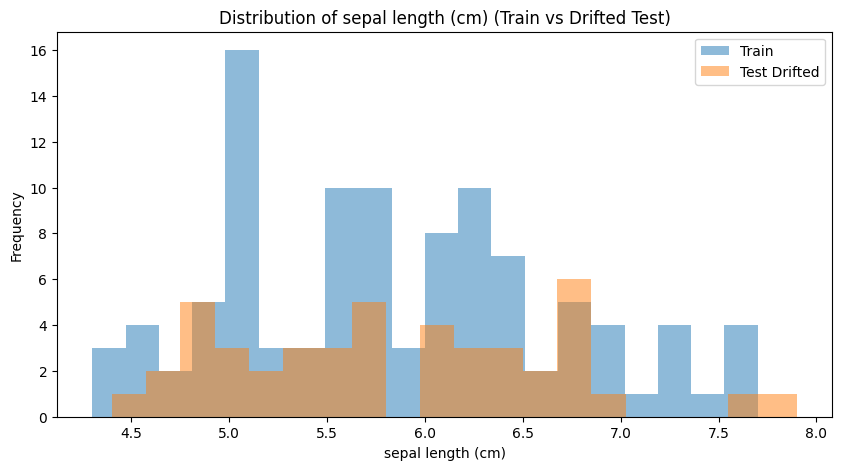

In [14]:
import matplotlib.pyplot as plt

feature = 'sepal length (cm)'
plt.figure(figsize=(10,5))
plt.hist(train[feature], bins=20, alpha=0.5, label='Train')
plt.hist(test_drifted[feature], bins=20, alpha=0.5, label='Test Drifted')
plt.title(f'Distribution of {feature} (Train vs Drifted Test)')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Statistical Drift Detection (Kolmogorov-Smirnov Test)


In [15]:
from scipy.stats import ks_2samp

def check_ks_drift(reference, current, feature, alpha=0.05):
    stat, p_value = ks_2samp(reference[feature], current[feature])
    print(f"KS Statistic: {stat:.3f}, p-value: {p_value:.4f}")
    if p_value < alpha:
        print(f"Drift detected in '{feature}' (p < {alpha})")
    else:
        print(f"No significant drift in '{feature}' (p >= {alpha})")

check_ks_drift(train, test_drifted, feature)


KS Statistic: 0.070, p-value: 0.9952
No significant drift in 'sepal length (cm)' (p >= 0.05)


## Monitoring Model Performance Drift

In [17]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluate performance on original test
acc_orig = accuracy_score(y_test, test['prediction'])
f1_orig = f1_score(y_test, test['prediction'], average='macro')

# Evaluate on drifted test
acc_drift = accuracy_score(y_test, test_drifted['prediction'])
f1_drift = f1_score(y_test, test_drifted['prediction'], average='macro')

print(f"Original Test Accuracy: {acc_orig:.2f}, F1 Score: {f1_orig:.2f}")
print(f"Drifted Test Accuracy: {acc_drift:.2f}, F1 Score: {f1_drift:.2f}")


Original Test Accuracy: 1.00, F1 Score: 1.00
Drifted Test Accuracy: 1.00, F1 Score: 1.00


## Set Simple Alerting

In [19]:
# Set a threshold for accuracy drop (e.g., drop > 0.1)
threshold = 0.1
if acc_orig - acc_drift > threshold:
    print("ALERT: Significant accuracy drop detected!")
else:
    print("Model accuracy is stable.")


Model accuracy is stable.


Set up a system to generate and store reports. Review them regularly or trigger alerts automatically.

**Best Practices:**
- Always monitor both data and model performance.
- Automate monitoring and alerting.
- Regularly retrain models if drift is detected.
- Document everything—monitoring config, thresholds, drift response.

**References:**  
- https://scikit-learn.org/